# Creating a RooFit Dataset from CMS Open Data with RDataFrame
**Requires ROOT v6.26 or later** (select the bleeding edge on SWAN if it doesn't work).

We use two NanoAOD-like input files with 66 mio. events
from the CMS OpenData. These contain muon candidates from the 2012 dataset
([DOI: 10.7483/OPENDATA.CMS.YLIC.86ZZ](http://opendata.cern.ch/record/6004)
and [DOI: 10.7483/OPENDATA.CMS.M5AD.Y3V3](http://opendata.cern.ch/record/6030)).

We select events with oppositely charged muons, and compute their invariant masses.
Note that the bump at 30 GeV is not a resonance but a trigger effect.

Some more details about the dataset:
  - It contains about 66 millions events (muon and electron collections, plus some other information, e.g. about primary vertices)
  - It spans two compressed ROOT files located on EOS for about a total size of 7.5 GB.




**Author:** Stephan Hageböck (CERN)

Define helper functions to label a plot and to compute an invariant mass.

In [1]:
%%cpp -d
#include "ROOT/RDataFrame.hxx"
#include "ROOT/RVec.hxx"
#include "TCanvas.h"
#include "TH1D.h"
#include "TLatex.h"
#include "Math/Vector4D.h"
#include "TStyle.h"
#include <iomanip>

using namespace ROOT::VecOps;
using namespace ROOT::Math;

/// A helper function to create 4-vectors from scalars
RVec<PtEtaPhiMVector> makeFromPtEtaPhiM(const RVec<float>& pT, const RVec<float>& eta,
                                        const RVec<float>& phi, const RVec<float>& M) {
    RVec<PtEtaPhiMVector> result;
    result.reserve(pT.size());
    for (unsigned int i=0; i < pT.size(); ++i) {
        result.emplace_back(pT[i], eta[i], phi[i], M[i]);
    }
    
    return result;
};

/// Labelling a plot
void labelPlot() {
    TLatex label; label.SetNDC(true);
    label.DrawLatex(0.175, 0.740, "#eta");
    label.DrawLatex(0.205, 0.775, "#rho,#omega");
    label.DrawLatex(0.270, 0.740, "#phi");
    label.DrawLatex(0.400, 0.800, "J/#psi");
    label.DrawLatex(0.415, 0.670, "#psi'");
    label.DrawLatex(0.485, 0.700, "Y(1,2,3S)");
    label.DrawLatex(0.755, 0.680, "Z");
    label.SetTextSize(0.040); label.DrawLatex(0.100, 0.920, "#bf{CMS Open Data}");
    label.SetTextSize(0.030); label.DrawLatex(0.630, 0.920, "#sqrt{s} = 8 TeV, L_{int} = 11.6 fb^{-1}");
};

Create dataframe from nanoaod files. We ask ROOT to enable multithreading if possible. On SWAN, we have 2 to 4 logical CPUs.

In [2]:
ROOT::EnableImplicitMT();
ROOT::RDataFrame df("Events",
                   {"root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root",
                    "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root"});

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly


Let's explore what's in the files:

In [3]:
df.GetColumnNames()

(ROOT::RDF::ColumnNames_t) { "run", "luminosityBlock", "event", "PV_npvs", "PV_x", "PV_y", "PV_z", "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge", "Muon_pfRelIso03_all", "Muon_pfRelIso04_all", "Muon_tightId", "Muon_softId", "Muon_dxy", "Muon_dxyErr", "Muon_dz", "Muon_dzErr", "nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", "Electron_charge", "Electron_pfRelIso03_all", "Electron_dxy", "Electron_dxyErr", "Electron_dz", "Electron_dzErr" }


How many events?

In [4]:
auto nEvt = df.Count();
*nEvt

(unsigned long long) 66128870


For simplicity, let's select only events with exactly two muons and require opposite charge.
Then, we compute the invariant mass of the dimuon system. For this, we use the helper function defined above, which creates a column with 4-vectors

In [5]:
auto df_filtered = df.Filter("nMuon == 2 && Muon_charge[0] * Muon_charge[1] < 0",
                             "Events with exactly two opposite-charge muons")
                     .Define("Muons", makeFromPtEtaPhiM,
                            {"Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass"})
                     .Define("Dimuon_mass", "(Muons[0] + Muons[1]).M()");

auto histo = df_filtered.Histo1D({"Dimuon_mass", "Dimuon_mass", 30000, 0.25, 300},
                                 "Dimuon_mass");

Let's also declare a RooFit dataset, which will be filled while RDataFrame processes the events

In [6]:
RooRealVar x("x", "Dimuon mass", 0, 150.);
RooDataSetHelper datasetConfig(
    "dataset",              // Name
    "Dimuon spectrum",      // Title
    RooArgSet{x}            // Variables in this dataset
);

auto rooDataSet = df_filtered.Book<double>(
    std::move(datasetConfig),
    {"Dimuon_mass"}             // Column names in RDataFrame.
);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Let's create a file and save the dataset in it. Now that the dataset is touched for the first time, RDataFrame starts processing the full 8 Gb.

In [7]:
TFile file("RFDataset.root", "RECREATE");
rooDataSet->Write();
file.Write();
file.Close();

Let's plot the histogram that was created during the RDataFrame run. Add `%jsroot on` in the first line if you want an interactive plot.

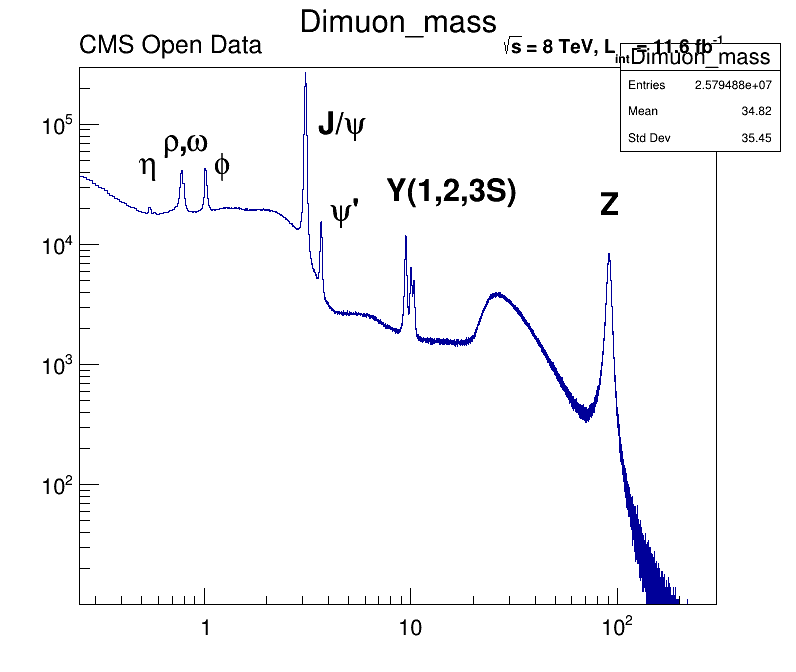

In [8]:
TCanvas* canv_all = new TCanvas("canv_all", "", 800, 700);
histo->GetYaxis()->SetRangeUser(10, 300000);
histo->Draw();

canv_all->SetLogx();
canv_all->SetLogy();

labelPlot();
canv_all->Draw();